In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pylab as pl
#import seaborn as sns
#import statsmodels.api as sm

#%matplotlib inline
#sns.set(style='white', font_scale=0.9)

data_directory = os.path.join('.', 'Fooddata') 

cleaned_data_path = os.path.join(data_directory, 'Reviews.csv')
print(cleaned_data_path)

.\Fooddata\Reviews.csv


In [13]:
#food_df = pd.read_csv(cleaned_data_path, low_memory=False, encoding='UTF-8')
food_df=pd.read_csv("C:/Users/mahesh/Desktop/Data_Science/FinalProject/Reviews.csv")
print(food_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
Id                        568454 non-null int64
ProductId                 568454 non-null object
UserId                    568454 non-null object
ProfileName               568438 non-null object
HelpfulnessNumerator      568454 non-null int64
HelpfulnessDenominator    568454 non-null int64
Score                     568454 non-null int64
Time                      568454 non-null int64
Summary                   568428 non-null object
Text                      568454 non-null object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB
None


In [15]:
#Using only columns needed 
df = food_df.iloc[:, [4,5,6,9]]
df.head()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Text
0,1,1,5,I have bought several of the Vitality canned d...
1,0,0,1,Product arrived labeled as Jumbo Salted Peanut...
2,1,1,4,This is a confection that has been around a fe...
3,3,3,2,If you are looking for the secret ingredient i...
4,0,0,5,Great taffy at a great price. There was a wid...


#### I have only included reviews that have more than 10 votes from users on whether the review was helpful or not. With this filter, the dataset is significantly reduce from 560,000+ reviews to 21,463 reviews.

In [18]:
#include reviews that have more than 10 helpfulness data point only
df = df[(df.HelpfulnessDenominator > 10)]
df['Score'].shape

(21463,)

In [19]:
#check for missing values
df.isnull().sum()

HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Text                      0
dtype: int64

# Feature Engineering
## Derived a column Helpful which is the ratio of HelpfulnessNumerator and HelpfulnessDenominator. It gives 1 if the ratio is greater than 0.5 else returns 0.

In [20]:
#transform Helpfulness into a binary variable with 0.50 ratio
food_df.loc[:, 'Helpful'] = np.where(food_df.loc[:, 'HelpfulnessNumerator'] / food_df.loc[:, 'HelpfulnessDenominator'] > 0.50, 1, 0)
food_df.head() 

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpful
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,0


In [22]:

df1.groupby('Helpful').count()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
Helpful,,,,,,,,,,
0,4100,4100,4100,4100,4100,4100,4100,4100,4075,4100
1,17363,17363,17363,17362,17363,17363,17363,17363,17363,17363


# Predicting the Helpfulness of Amazon Fine Food Reviews

Purpose
Build a model to predict the helpfulness of Amazon Fine Food Reviews. This will improve Amazon's selection of helpful reviews at the top of the review section and improve customer's purchasing decisions. It could also help other reviewers as a guide to writing helpful reviews.

## 1.  Bag of words model

In [23]:

#make a copy
df2 = df1.copy(deep = True)

In [24]:
#tokenize text with Tfidf
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df = 0.1, max_df=0.9,
                             ngram_range=(1, 4), 
                             stop_words='english')
vectorizer.fit(df2['Text'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9, max_features=None, min_df=0.1,
        ngram_range=(1, 4), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [25]:

X_train = vectorizer.transform(df2['Text'])
vocab = vectorizer.get_feature_names()

In [26]:
#find best logistic regression parameters
from sklearn import grid_search, cross_validation
from sklearn.linear_model import LogisticRegression
feature_set = X_train
gs = grid_search.GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={'C': [10**-i for i in range(-5, 5)], 'class_weight': [None, 'balanced']},
    cv=cross_validation.StratifiedKFold(df1.Helpful,n_folds=10),
    scoring='roc_auc'
)


gs.fit(X_train, df2.Helpful)
gs.grid_scores_

C:\Users\mahesh\Miniconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\mahesh\Miniconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


[mean: 0.71938, std: 0.01106, params: {'class_weight': None, 'C': 100000},
 mean: 0.71991, std: 0.01112, params: {'class_weight': 'balanced', 'C': 100000},
 mean: 0.71938, std: 0.01106, params: {'class_weight': None, 'C': 10000},
 mean: 0.71991, std: 0.01112, params: {'class_weight': 'balanced', 'C': 10000},
 mean: 0.71938, std: 0.01106, params: {'class_weight': None, 'C': 1000},
 mean: 0.71991, std: 0.01112, params: {'class_weight': 'balanced', 'C': 1000},
 mean: 0.71938, std: 0.01106, params: {'class_weight': None, 'C': 100},
 mean: 0.71990, std: 0.01112, params: {'class_weight': 'balanced', 'C': 100},
 mean: 0.71937, std: 0.01105, params: {'class_weight': None, 'C': 10},
 mean: 0.71990, std: 0.01113, params: {'class_weight': 'balanced', 'C': 10},
 mean: 0.71949, std: 0.01114, params: {'class_weight': None, 'C': 1},
 mean: 0.71994, std: 0.01116, params: {'class_weight': 'balanced', 'C': 1},
 mean: 0.71917, std: 0.01111, params: {'class_weight': None, 'C': 0.1},
 mean: 0.71948, std: 0

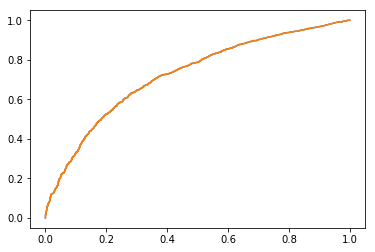

In [28]:

#plot ROC/AUC curve
from sklearn.metrics import roc_auc_score, roc_curve
actuals = gs.predict(feature_set) 
probas = gs.predict_proba(feature_set)
plt.plot(roc_curve(df2[['Helpful']], probas[:,1])[0], roc_curve(df2[['Helpful']], probas[:,1])[1])
plt.show()

In [29]:
# ROC/AUC score
y_score = probas
test2 = np.array(list(df2.Helpful))
test2 = test2.reshape(21463,1)
y_true = test2
roc_auc_score(y_true, y_score[:,1].T)

0.72341319430299644

## The Bag of Words model performs poorly with only 72% accuracy.

# Improving Prediction with K-Means Clustering of Reviews


In [30]:
#Apply TfidfVectorizer to review text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn import metrics

# 2. K-Means Clustering of Reviews

In [31]:

model = KMeans(n_clusters=4, init='k-means++', max_iter=100, n_init=1,random_state=5)

vectorizer = TfidfVectorizer(min_df = 0.05, max_df=0.95,
                             ngram_range=(1, 2), 
                             stop_words='english')
vectorizer.fit(df1['Text'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.95, max_features=None, min_df=0.05,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [32]:

X_train = vectorizer.transform(df1['Text'])
vocab = vectorizer.get_feature_names()
sse_err = []
res = model.fit(X_train)
vocab = np.array(vocab)
cluster_centers = np.array(res.cluster_centers_)
sorted_vals = [res.cluster_centers_[i].argsort() for i in range(0,np.shape(res.cluster_centers_)[0])]
words=set()
for i in range(len(res.cluster_centers_)):
    words = words.union(set(vocab[sorted_vals[i][-10:]]))
words=list(words)

In [33]:
#top 10 words for each cluster
words

['great',
 'br',
 'product',
 'tried',
 'price',
 'food',
 'coffee',
 'cup',
 'like',
 'flavor',
 'buy',
 'good',
 'taste',
 'bags',
 'amazon',
 'cups',
 'tea',
 'drink',
 'just',
 'br br']

In [34]:

#add top words to train set
train_set=X_train[:,[np.argwhere(vocab==i)[0][0] for i in words]]

In [36]:
# how many observations are in each cluster
df1['cluster'] = model.labels_
df1.groupby('cluster').count()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpful
cluster,,,,,,,,,,,
0,12653,12653,12653,12652,12653,12653,12653,12653,12653,12653,12653
1,1179,1179,1179,1179,1179,1179,1179,1179,1154,1179,1179
2,6021,6021,6021,6021,6021,6021,6021,6021,6021,6021,6021
3,1610,1610,1610,1610,1610,1610,1610,1610,1610,1610,1610


In [37]:

# what does each cluster look like
df1.groupby('cluster').mean()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Helpful
cluster,,,,,,
0,286385.466767,16.309018,21.438394,3.243658,1.249917e+09,0.778472
1,285864.908397,16.469890,20.156064,3.871077,1.233300e+09,0.840543
2,285761.001329,24.020429,28.874439,3.538947,1.255138e+09,0.845873
3,293390.230435,35.873292,39.247826,3.837267,1.265179e+09,0.887578


In [38]:

# correlation matrix
df1.corr()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Helpful,cluster
Id,1.000000,0.000854,0.000040,0.003925,-0.010021,0.003544,0.005369
HelpfulnessNumerator,0.000854,1.000000,0.975746,0.145338,-0.015559,0.228370,0.157978
HelpfulnessDenominator,0.000040,0.975746,1.000000,0.048775,-0.012100,0.080156,0.143434
Score,0.003925,0.145338,0.048775,1.000000,-0.221110,0.457537,0.105685
Time,-0.010021,-0.015559,-0.012100,-0.221110,1.000000,-0.055558,0.066296
Helpful,0.003544,0.228370,0.080156,0.457537,-0.055558,1.000000,0.095398
cluster,0.005369,0.157978,0.143434,0.105685,0.066296,0.095398,1.000000


## Logistic Regression to Predict Review Helpfulness with Top Cluster Words


In [39]:

print(train_set.shape)

(21463, 20)


In [40]:

#add Score column to top words
import scipy as scipy

score = np.array(list(df1.Score))
score = score.reshape(21463, 1)

features = scipy.sparse.hstack((train_set,scipy.sparse.csr_matrix(score)))

features = scipy.sparse.csr_matrix(features)

In [41]:

features.shape

(21463, 21)

In [42]:

#find best logistic regression parameters
from sklearn import grid_search, cross_validation
from sklearn.linear_model import LogisticRegression
feature_set = features
gs = grid_search.GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={'C': [10**-i for i in range(-5, 5)], 'class_weight': [None, 'balanced']},
    cv=cross_validation.StratifiedKFold(df1.Helpful,n_folds=10),
    scoring='roc_auc'
)


gs.fit(features, df1.Helpful)
gs.grid_scores_

[mean: 0.82603, std: 0.01467, params: {'class_weight': None, 'C': 100000},
 mean: 0.82604, std: 0.01440, params: {'class_weight': 'balanced', 'C': 100000},
 mean: 0.82603, std: 0.01467, params: {'class_weight': None, 'C': 10000},
 mean: 0.82604, std: 0.01440, params: {'class_weight': 'balanced', 'C': 10000},
 mean: 0.82603, std: 0.01467, params: {'class_weight': None, 'C': 1000},
 mean: 0.82604, std: 0.01440, params: {'class_weight': 'balanced', 'C': 1000},
 mean: 0.82604, std: 0.01467, params: {'class_weight': None, 'C': 100},
 mean: 0.82604, std: 0.01440, params: {'class_weight': 'balanced', 'C': 100},
 mean: 0.82601, std: 0.01467, params: {'class_weight': None, 'C': 10},
 mean: 0.82604, std: 0.01440, params: {'class_weight': 'balanced', 'C': 10},
 mean: 0.82578, std: 0.01471, params: {'class_weight': None, 'C': 1},
 mean: 0.82598, std: 0.01438, params: {'class_weight': 'balanced', 'C': 1},
 mean: 0.82415, std: 0.01512, params: {'class_weight': None, 'C': 0.1},
 mean: 0.82492, std: 0

In [43]:
print(gs.best_estimator_)

LogisticRegression(C=10000, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [44]:

y_pred = gs.predict(feature_set)

In [45]:

# Coefficients represent the log-odds
print(gs.best_estimator_.coef_)
print(gs.best_estimator_.intercept_)

[[ 1.30479982 -0.2908615  -0.10621725  0.32669208  1.20554882  1.41706685
   0.77525596  1.91792625 -0.26673208  1.57378091 -0.10151496  0.11688436
   0.34616558  0.93702072  0.63539321  0.1731905   0.28481941 -1.34654752
   0.11149571  2.19661098  0.76754533]]
[-2.4734059]


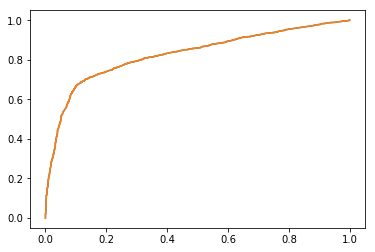

In [47]:
#roc curve
from sklearn.metrics import roc_auc_score, roc_curve
actuals = gs.predict(feature_set) 
probas = gs.predict_proba(feature_set)
plt.plot(roc_curve(df1[['Helpful']], probas[:,1])[0], roc_curve(df1[['Helpful']], probas[:,1])[1])
plt.show()

In [48]:

#roc auc score
y_score = probas
test2 = np.array(list(df1.Helpful))
test2 = test2.reshape(21463,1)
y_true = test2

roc_auc_score(y_true, y_score[:,1].T)

0.82711888049019289

In [52]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))


             precision    recall  f1-score   support

          0       0.42      0.82      0.55      4100
          1       0.94      0.73      0.82     17363

avg / total       0.84      0.75      0.77     21463



Confusion matrix, without normalization
[[ 3342   758]
 [ 4646 12717]]
Normalized confusion matrix
[[ 0.82  0.18]
 [ 0.27  0.73]]


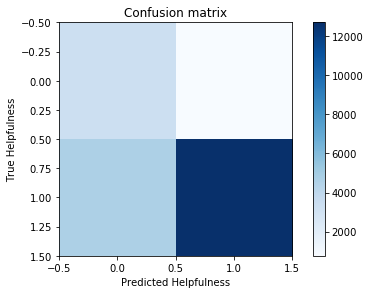

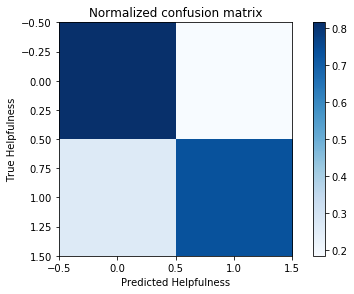

In [49]:
#plot a confusion matrix
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True Helpfulness')
    plt.xlabel('Predicted Helpfulness')


# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()

In [50]:
#view top parameters
words.extend(['score'])
sorted(zip(words,gs.best_estimator_.coef_[0]),key=lambda x:x[1])

[('drink', -1.3465475201841786),
 ('br', -0.29086150403825239),
 ('like', -0.26673207913639135),
 ('product', -0.10621724500546934),
 ('buy', -0.10151495827452782),
 ('just', 0.11149570699571824),
 ('good', 0.11688435646711319),
 ('cups', 0.17319049642855375),
 ('tea', 0.28481940574322434),
 ('tried', 0.32669208392946208),
 ('taste', 0.34616558010986292),
 ('amazon', 0.63539320832179558),
 ('score', 0.7675453262214702),
 ('coffee', 0.77525595704181871),
 ('bags', 0.9370207150285802),
 ('price', 1.2055488192692585),
 ('great', 1.3047998205032945),
 ('food', 1.4170668457268814),
 ('flavor', 1.5737809055661804),
 ('cup', 1.9179262497350158),
 ('br br', 2.1966109768902853)]


### There seem to be common words that I should remove from the text in further analysis, like food, product, or Amazon. My model is 82% accurate, which is 10% increase in accuracy over the Bag of Words model.

## Recommendations
### Price, Flavor, and Great are the top indicators of a helpful review. This indicates a possible bias among customers to mark a review as helpful when the review is positive. Eating, Like, Don't, Order, Good, and Eat are all negatively correlated with a helpful review, which is difficult to interpret. These may be more common words to remove.